# Simple RNN for time series generation

### Method

Heavily based on GeeksForGeeks guide "Multivariate Time Series Forecasting with LSTMs in Keras" available on [this website](https://www.geeksforgeeks.org/multivariate-time-series-forecasting-with-lstms-in-keras/)

In [2]:
import datetime
import sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import KernelPCA
import numpy as np
import pandas as pd
import math
import keras
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from utils import plot_loc_right
tf.random.set_seed(99)

2024-05-26 14:24:22.539843: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-26 14:24:23.635521: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-26 14:24:23.647067: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-26 14:24:26.679859: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
dim = 9
# data = np.loadtxt(f'sine_data/sine_123_1000_{dim}.csv', delimiter = ",",skiprows = 1) # Simple sine
# data = np.loadtxt(f'complex_sine_data/extra_comp_sine_123_1000_{dim}.csv', delimiter = ",",skiprows = 1) # Complex sine
data = np.loadtxt(f'data/sensor_data_norm2_indexless_10days.csv', delimiter = ",",skiprows = 1)
data = pd.DataFrame(data)

In [4]:
imputer = SimpleImputer(missing_values=np.nan) # Handling missing values
dataFrame = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)
dataFrame = dataFrame.reset_index(drop=True)
# Applying feature scaling
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(dataFrame.to_numpy())
df_scaled = pd.DataFrame(df_scaled, columns=list(dataFrame.columns))
target_scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = target_scaler.fit_transform(dataFrame.to_numpy())
df_scaled = pd.DataFrame(df_scaled.astype(float))


In [5]:
# Single step dataset preparation
def singleStepSampler(df, window):
	xRes = []
	yRes = []
	for i in range(0, len(df) - window):
		res = []
		for j in range(0, window):
			r = []
			for col in df.columns:
				r.append(df[col][i + j])
			res.append(r)
		xRes.append(res)
		yRes.append(df.iloc[i + window].values)
	return np.array(xRes), np.array(yRes)


In [14]:
# Dataset splitting
SPLIT = 0.99
(xVal, yVal) = singleStepSampler(df_scaled, 20)
X_train = xVal[:int(SPLIT * len(xVal))]
y_train = yVal[:int(SPLIT * len(yVal))]
X_test = xVal[int(SPLIT * len(xVal)):]
y_test = yVal[int(SPLIT * len(yVal)):]
horizon = 100


In [15]:

multivariate_lstm = keras.Sequential()
multivariate_lstm.add(keras.layers.LSTM(200, input_shape=(X_train.shape[1], X_train.shape[2])))
multivariate_lstm.add(keras.layers.Dropout(0.2))
multivariate_lstm.add(keras.layers.Dense(dim, activation='linear'))
multivariate_lstm.compile(loss = 'MeanSquaredError', metrics=['MAE'], optimizer='Adam')
multivariate_lstm.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 200)               168000    
                                                                 
 dropout_2 (Dropout)         (None, 200)               0         
                                                                 
 dense_2 (Dense)             (None, 9)                 1809      
                                                                 
Total params: 169,809
Trainable params: 169,809
Non-trainable params: 0
_________________________________________________________________


2024-05-26 18:46:38.907073: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-26 18:46:38.910844: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-26 18:46:38.914429: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [16]:
history = multivariate_lstm.fit(X_train, y_train, epochs=20)


Epoch 1/20


2024-05-26 18:46:45.171141: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-26 18:46:45.175750: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-26 18:46:45.179774: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

891/891 [==============================] - 84s 89ms/step - loss: 0.0050 - MAE: 0.0520
Epoch 2/20
891/891 [==============================] - 88s 99ms/step - loss: 0.0028 - MAE: 0.0396
Epoch 3/20
891/891 [==============================] - 91s 102ms/step - loss: 0.0024 - MAE: 0.0361
Epoch 4/20
891/891 [==============================] - 90s 101ms/step - loss: 0.0022 - MAE: 0.0339
Epoch 5/20
891/891 [==============================] - 96s 107ms/step - loss: 0.0020 - MAE: 0.0328
Epoch 6/20
891/891 [==============================] - 78s 88ms/step - loss: 0.0019 - MAE: 0.0316
Epoch 7/20
891/891 [==============================] - 75s 85ms/step - loss: 0.0018 - MAE: 0.0306
Epoch 8/20
891/891 [==============================] - 70s 79ms/step - loss: 0.0018 - MAE: 0.0300
Epoch 9/20
891/891 [==============================] - 70s 78ms/step - loss: 0.0017 - MAE: 0.0294
Epoch 10/20
891/891 [==============================] - 67s 75ms/step - loss: 0.0016 - MAE: 0.0288
Epoch 11/20
891/891 [================

In [21]:
horizon = 24
predicted_values = multivariate_lstm.predict(X_test[:horizon])

1/1 [==============================] - 0s 50ms/step


<class 'numpy.ndarray'>


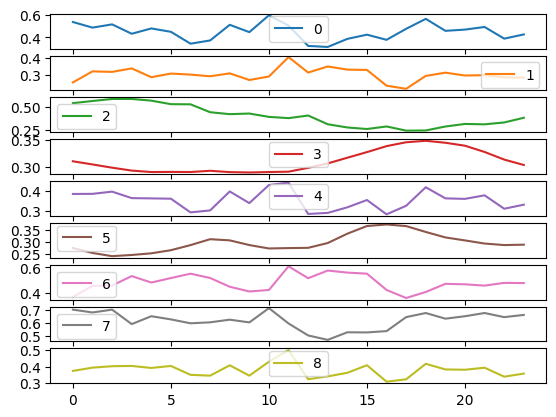

: 

In [22]:
import os
print(type(predicted_values))
pred_df = pd.DataFrame(predicted_values)
pred_df.plot(subplots=True)

# Save generated data to csv
x = datetime.datetime.now()

timestamp = x.strftime("%d%m%y_%Hh%M")
# generated_df = list_to_df(generated_data)

filepath = os.path.join('synt_data', 'exp3', f'lstm_sensor_{horizon}_{timestamp}.csv')
# filepath = os.path.join('synthetic_complex_sines', 'lstm', f'extra_comp_syn_sine_{dim}_{horizon}_{timestamp}.csv')
if dim == 1:
    pred_df.to_csv(filepath)
else:
    pred_df.to_csv(filepath, index=False)

## Generated simple sine from LSTM

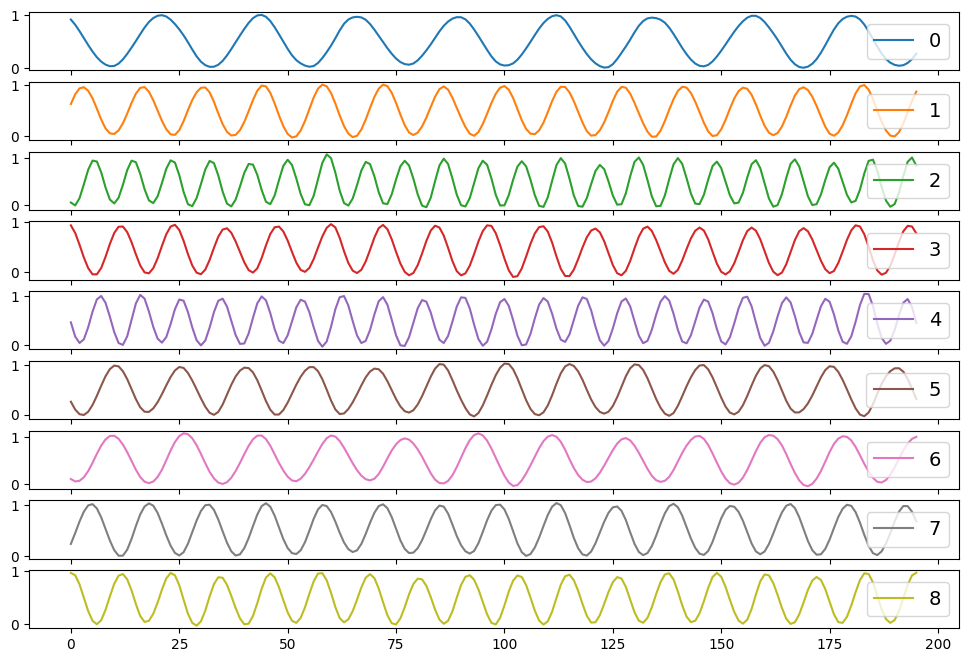

In [4]:
lstm_9 = pd.DataFrame(np.loadtxt(os.path.join('synt_data', 'lstm', 'lstm_sine_9_196_140524_13h34.csv'), delimiter = ",",skiprows = 1))
plot_loc_right(lstm_9, subplots=True)